# Optimized WhatsApp Analyzer

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from tkinter import Tk, filedialog

In [2]:
# STOP WORDS
STOP_WORDS = {
    "the","and","for","that","this","with","you","your","are","was","have",
    "has","but","not","from","they","their","will",
    "media","omitted","dey","una","don","wan","sef","make","message","sha","say","see"
}

In [3]:
# CLEAN TEXT
def clean_text(text):
    words = re.findall(r'\b[a-zA-Z]{3,}\b', str(text).lower())
    return [w for w in words if w not in STOP_WORDS]

📂 Processing: C:/Users/HP/OneDrive/Desktop/Python Script/WhatsApp Chat with Gs.txt
📊 Rendering basic analysis charts...


C:\Users\HP\AppData\Local\Temp\ipykernel_13960\2532492946.py:48: UserWarning: Glyph 129760 (\N{MELTING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129760 (\N{MELTING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


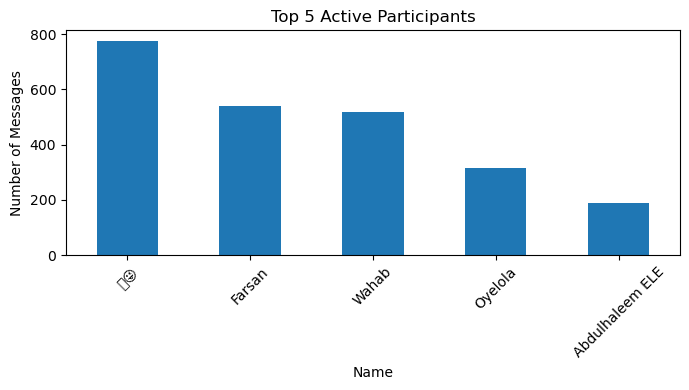

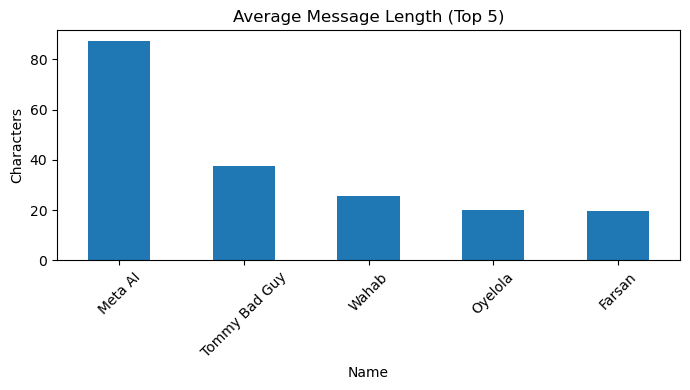

⏰ Rendering hourly activity charts...


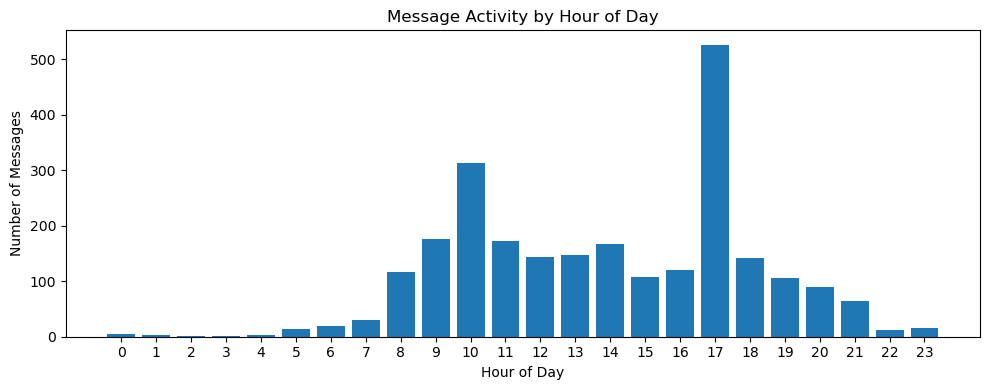

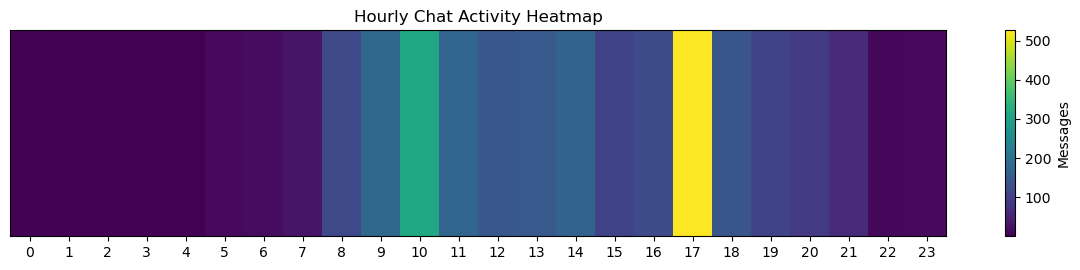

☁️ Rendering Word Clouds...


C:\Users\HP\AppData\Local\Temp\ipykernel_13960\2532492946.py:125: UserWarning: Glyph 129760 (\N{MELTING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129760 (\N{MELTING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


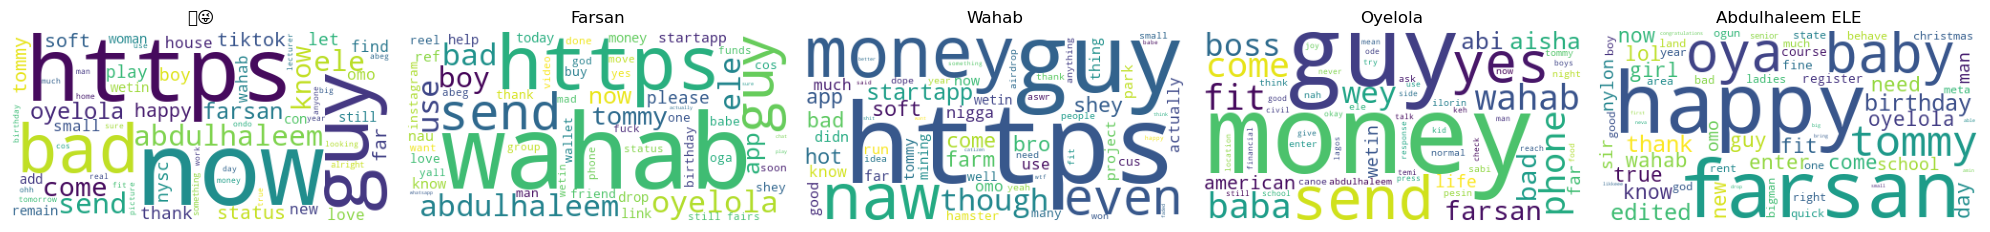


--- Top 5 Words per Sender ---
👤 🫠😜: ['now', 'https', 'com', 'like', 'bad']
👤 Farsan: ['wahab', 'https', 'how', 'guy', 'send']
👤 Wahab: ['just', 'https', 'get', 'like', 'all']
👤 Oyelola: ['money', 'like', 'send', 'yes', 'wahab']
👤 Abdulhaleem ELE: ['happy', 'farsan', 'how', 'all', 'baby']

✅ Analysis complete. File saved as cleaned_whatsapp_chat.csv


In [4]:
# MAIN ANALYSIS

def perform_analysis(file_path):
    print(f"📂 Processing: {file_path}")

    # WhatsApp regex (AM/PM supported)
    pattern = re.compile(
    r'^(\d{1,2}[\/.-]\d{1,2}[\/.-]\d{2,4}),\s'
    r'(\d{1,2}:\d{2}(?:\s?[APMapm]{2})?)\s-\s'
    r'([^:]+):\s(.*)$'
)

    data = []
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            match = pattern.match(line)
            if match:
                data.append(match.groups())

    df = pd.DataFrame(data, columns=['Date', 'Time', 'Name', 'Message'])

    if df.empty:
        print("❌ Parsing failed.")
        return

    # BASIC METRICS
    df['Length'] = df['Message'].str.len()

    # Extract hour safely (handles WhatsApp narrow spaces)
    df['Hour'] = pd.to_datetime(
        df['Time'].str.replace('\u202f', ' ', regex=False),
        format='%I:%M %p',
        errors='coerce'
    ).dt.hour

    top_senders = df['Name'].value_counts().head(5)

    # BASIC ANALYSIS CHARTS
    
    print("📊 Rendering basic analysis charts...")

    # Top 5 active people
    plt.figure(figsize=(7,4))
    top_senders.plot(kind='bar')
    plt.title("Top 5 Active Participants")
    plt.ylabel("Number of Messages")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Average message length
    avg_length = (
        df.groupby('Name')['Length']
        .mean()
        .sort_values(ascending=False)
        .head(5)
    )

    plt.figure(figsize=(7,4))
    avg_length.plot(kind='bar')
    plt.title("Average Message Length (Top 5)")
    plt.ylabel("Characters")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # HOUR-OF-DAY ACTIVITY
    print("⏰ Rendering hourly activity charts...")

    hourly_counts = df['Hour'].value_counts().sort_index()

    # Hourly bar chart
    plt.figure(figsize=(10,4))
    plt.bar(hourly_counts.index, hourly_counts.values)
    plt.xticks(range(0,24))
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Messages")
    plt.title("Message Activity by Hour of Day")
    plt.tight_layout()
    plt.show()

    # Hourly heatmap
    plt.figure(figsize=(12,2.8))
    plt.imshow(
        [hourly_counts.reindex(range(24), fill_value=0)],
        aspect='auto'
    )
    plt.yticks([])
    plt.xticks(range(24), range(24))
    plt.colorbar(label="Messages")
    plt.title("Hourly Chat Activity Heatmap")
    plt.tight_layout()
    plt.show()

    # WORD CLOUDS
    print("☁️ Rendering Word Clouds...")

    valid_names = []
    texts = []

    for name in top_senders.index:
        combined = " ".join(df[df['Name'] == name]['Message'])
        words = clean_text(combined)
        if len(words) > 5:
            valid_names.append(name)
            texts.append(" ".join(words))

    fig, axes = plt.subplots(
        1, len(valid_names),
        figsize=(4 * len(valid_names), 4),
        squeeze=False
    )

    for ax, name, text in zip(axes[0], valid_names, texts):
        wc = WordCloud(
            background_color="white",
            max_words=60,
            collocations=False
        ).generate(text)

        ax.imshow(wc)
        ax.set_title(name)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    # NLP SUMMARY
    print("\n--- Top 5 Words per Sender ---")
    for name in top_senders.index:
        tokens = []
        for msg in df[df['Name'] == name]['Message']:
            tokens.extend(clean_text(msg))
        print(f"👤 {name}: {[w for w, _ in Counter(tokens).most_common(5)]}")

    # Save cleaned file
    df.to_csv("cleaned_whatsapp_chat.csv", index=False)
    print("\n✅ Analysis complete. File saved as cleaned_whatsapp_chat.csv")

# FILE PICKER
def run_app():
    root = Tk()
    root.withdraw()
    root.attributes('-topmost', True)

    file_path = filedialog.askopenfilename(
        title="Select WhatsApp Chat",
        filetypes=[("Text Files", "*.txt")]
    )
    root.destroy()

    if file_path:
        perform_analysis(file_path)
    else:
        print("❌ No file selected.")

run_app()
